<a href="https://colab.research.google.com/github/handesarica/breast_cancer_classification/blob/main/BreastCancer_Classification_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project Description ###

This project is developed for doctoral course within Erciyes University Computer Engineering. The project aim determine the breast images classification using deep learning methods for detect the breast cancer in early phase. 

Course Instructor: Assoc. Prof. Dr. Tayyip Özcan

### Importing Libraries ###

Importing the required libraries in this area

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix
import itertools

### Dataset Implemantation ###

Dataset is used from Google Drive for sharing collaboration.

First step for implementing the dataset is necessary the mount Google Drive and files location.


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = "../content/drive/MyDrive/DeepLearning_PhD/datasets/train"

In [ ]:
image_dir = Path(data)

filepaths = list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.png')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
labels

0       malignant
1       malignant
2       malignant
3       malignant
4       malignant
          ...    
1573       benign
1574       benign
1575       benign
1576       benign
1577       benign
Name: Label, Length: 1578, dtype: object

In [ ]:
filepaths

0       ../content/drive/MyDrive/DeepLearning_PhD/data...
1       ../content/drive/MyDrive/DeepLearning_PhD/data...
2       ../content/drive/MyDrive/DeepLearning_PhD/data...
3       ../content/drive/MyDrive/DeepLearning_PhD/data...
4       ../content/drive/MyDrive/DeepLearning_PhD/data...
                              ...                        
1573    ../content/drive/MyDrive/DeepLearning_PhD/data...
1574    ../content/drive/MyDrive/DeepLearning_PhD/data...
1575    ../content/drive/MyDrive/DeepLearning_PhD/data...
1576    ../content/drive/MyDrive/DeepLearning_PhD/data...
1577    ../content/drive/MyDrive/DeepLearning_PhD/data...
Name: Filepath, Length: 1578, dtype: object

Samples of breast ultrasound images

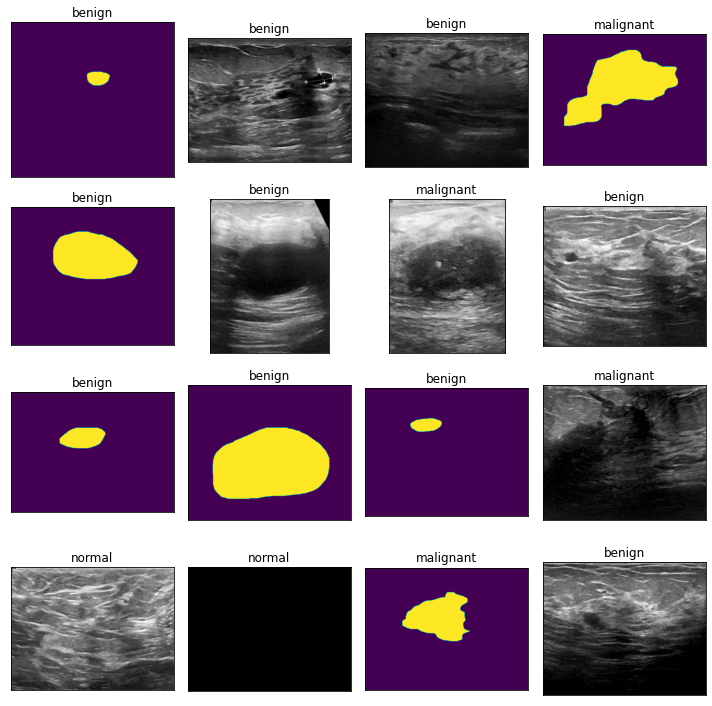

In [ ]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
# create prepare_image method
# used to preprocess the image for efficientNet model
IMAGE_SHAPE = (224, 224)

def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

In [ ]:
import glob

directories = os.listdir(data) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:
    
    fileList = glob.glob(data + '/'+ folder + '/*')
    labels.extend([folder for l in fileList])
    files.extend(fileList)
    
len(files), len(labels)

(1578, 1578)

Separate datamask images in dataset

In [ ]:
# create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

    
len(selected_files), len(selected_labels)

(780, 780)

In [ ]:
# the dictionary holds list of images and for each one has its target/label
images = {
    'image': [], 
    'target': []
}

for i, (file, label) in enumerate(zip(selected_files, selected_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)
    
print('Finished.')

Finished.


In [ ]:
# convert lists to arrays 
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


### Dataset Split ###

Split the data to train and test

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((702, 224, 224, 3), (78, 224, 224, 3), (702,), (78,))

### CNN Model Process: VGG16 ###

VGG model create using Keras

In [ ]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
# incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

incept_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

incept_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

### Model Training and Evaluation ###

In [ ]:
history = incept_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
22/22 [==============================] - 28s 616ms/step - loss: 0.8417 - accuracy: 0.6353 - val_loss: 1.0636 - val_accuracy: 0.5513
Epoch 2/10
22/22 [==============================] - 3s 151ms/step - loss: 0.5700 - accuracy: 0.7721 - val_loss: 0.9782 - val_accuracy: 0.5513
Epoch 3/10
22/22 [==============================] - 3s 152ms/step - loss: 0.4269 - accuracy: 0.8362 - val_loss: 0.9279 - val_accuracy: 0.5641
Epoch 4/10
22/22 [==============================] - 3s 152ms/step - loss: 0.3141 - accuracy: 0.9003 - val_loss: 0.9221 - val_accuracy: 0.6154
Epoch 5/10
22/22 [==============================] - 3s 154ms/step - loss: 0.2394 - accuracy: 0.9330 - val_loss: 0.9366 - val_accuracy: 0.6282
Epoch 6/10
22/22 [==============================] - 3s 155ms/step - loss: 0.1999 - accuracy: 0.9416 - val_loss: 0.8665 - val_accuracy: 0.6410
Epoch 7/10
22/22 [==============================] - 3s 156ms/step - loss: 0.1667 - accuracy: 0.9615 - val_loss: 0.8969 - val_accuracy: 0.6667
Epoch

In [ ]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 0s 107ms/step - loss: 0.6365 - accuracy: 0.7308


[0.6364690065383911, 0.7307692170143127]

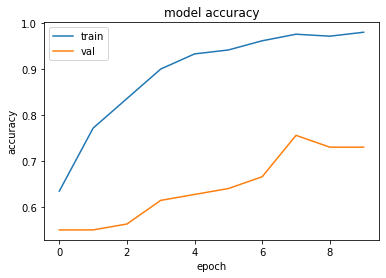

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Predict the model

In [ ]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = incept_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

1/1 [==============================] - 1s 1s/step


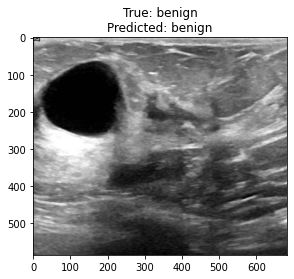

In [ ]:
predict_image(data + '/benign/benign (10).png', 'benign')

1/1 [==============================] - 0s 18ms/step


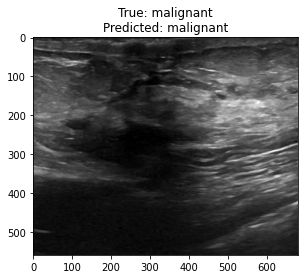

In [ ]:
predict_image(data + '/malignant/malignant (60).png', 'malignant')

1/1 [==============================] - 0s 16ms/step


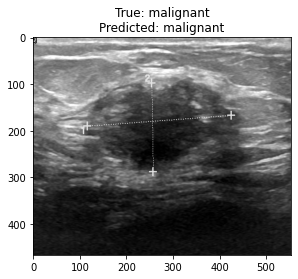

In [ ]:
predict_image(data + '/malignant/malignant (122).png', 'malignant')

1/1 [==============================] - 0s 15ms/step


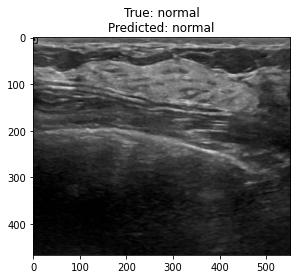

In [ ]:
predict_image(data + '/normal/normal (87).png', 'normal')

Visualize the data

In [ ]:
predicted = []
for item in incept_model.predict(x_test):
    predicted.append(np.argmax(item))

3/3 [==============================] - 0s 141ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test,predicted)
conf

array([[38,  5,  0],
       [ 5, 12,  1],
       [ 9,  1,  7]])

Text(0.5, 117.59999999999997, 'Predicted')

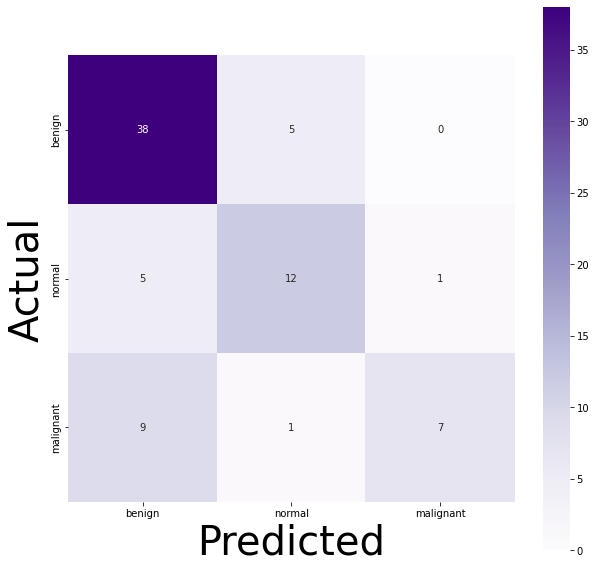

In [ ]:
#Heatmap
info = [
    'benign'   ,  # 0
    'normal'   ,  # 1
    'malignant',  # 2
]
plt.figure(figsize = (10,10))
ax = sns.heatmap(conf, cmap=plt.cm.Purples, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)